In [2]:
pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ----- ---------------------------------- 10.7/72.0 MB 56.1 MB/s eta 0:00:02
   ------------- -------------------------- 23.9/72.0 MB 58.1 MB/s eta 0:00:01
   --------------------- ------------------ 39.6/72.0 MB 62.9 MB/s eta 0:00:01
   ------------------------------- -------- 56.6/72.0 MB 66.9 MB/s eta 0:00:01
   ---------------------------------------  70.8/72.0 MB 67.4 MB/s eta 0:00:01
   ---------------------------------------- 72.0/72.0 MB 62.1 MB/s  0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import mlflow
from mlflow.models import infer_signature
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import (
    mean_squared_error, r2_score,mean_absolute_error
)
import datetime as dt


In [6]:
data = pd.read_csv("day_2011.csv")
data.head()

,dteday,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01/01/2011,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,02/01/2011,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,03/01/2011,1,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,04/01/2011,1,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,05/01/2011,1,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600


In [7]:
data['dteday'] = pd.to_datetime(data['dteday'], dayfirst=True)
data['day'] = data['dteday'].dt.day
data['year'] = data['dteday'].dt.year
data.drop(columns=['dteday'], inplace=True)

In [8]:
data.dtypes

season          int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
cnt             int64
day             int32
year            int32
dtype: object

In [4]:
data.head()

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,day,year
0,1,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985,1,2011
1,1,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801,2,2011
2,1,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349,3,2011
3,1,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562,4,2011
4,1,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600,5,2011


In [5]:
num_cols = [c for c in data.columns if data[c].dtype in ['int64', 'float64']]
cat_cols = [c for c in data.columns if data[c].dtype == 'object']

print(num_cols, cat_cols)

['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt'] []


In [6]:
data[num_cols].describe()

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,2.498630,6.526027,0.027397,3.008219,0.684932,1.421918,0.486665,0.466835,0.643665,0.191403,3405.761644
std,1.110946,3.452584,0.163462,2.006155,0.465181,0.571831,0.189596,0.168836,0.148744,0.076890,1378.753666
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,431.000000
25%,2.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.325000,0.321954,0.538333,0.135583,2132.000000
50%,3.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.479167,0.472846,0.647500,0.186900,3740.000000
75%,3.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.656667,0.612379,0.742083,0.235075,4586.000000
max,4.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.849167,0.840896,0.972500,0.507463,6043.000000


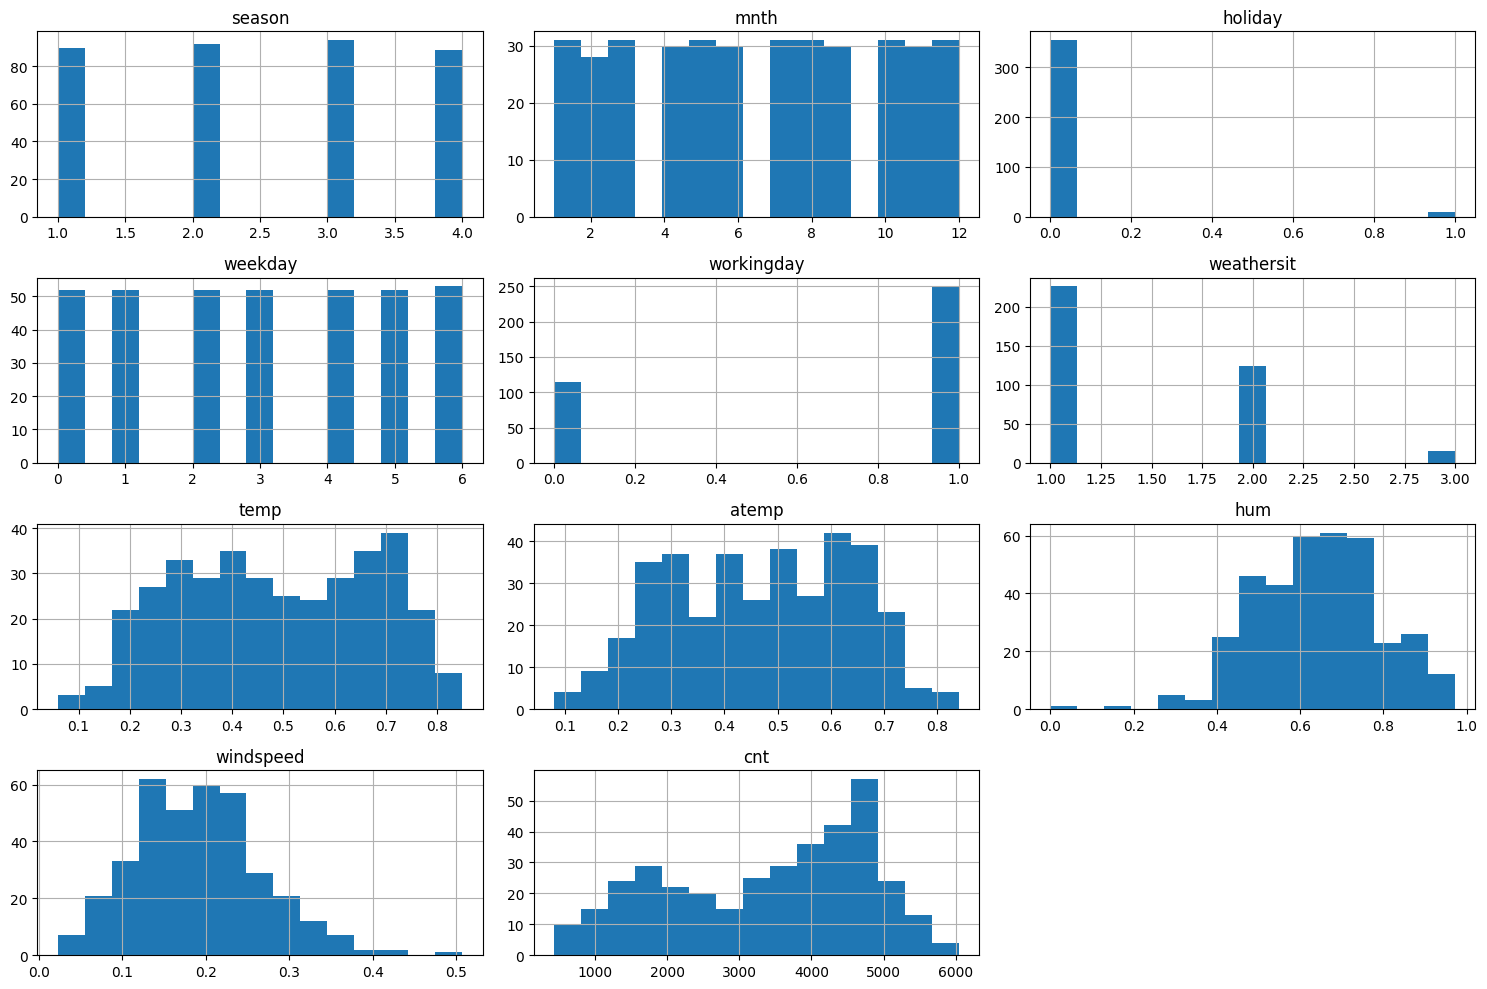

In [7]:
data[num_cols].hist(bins=15, figsize=(15, 10))
plt.tight_layout()

After checking the distribution, we can see that the data is quite normalized and likely will not need additional transformations/scaling. It was previously mentioned that some scaling has already been done. However, we can notice that there are a number of numerical values that are actually categorical data with integer values. We must address this using encoding as the linear regression model may misinterpret this, which would affect the model performance.

In [8]:
# since the baseline model will be a linear regression model, we will use one hot encoding for season, mnth, holiday, weekday, workingday, weathersit
data = pd.get_dummies(data, columns=['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'], drop_first=True, dtype=int)
data.head()

,temp,atemp,hum,windspeed,cnt,day,year,season_2,season_3,season_4,...,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
0,0.344167,0.363625,0.805833,0.160446,985,1,2011,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0.363478,0.353739,0.696087,0.248539,801,2,2011,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0.196364,0.189405,0.437273,0.248309,1349,3,2011,0,0,0,...,0,1,0,0,0,0,0,1,0,0
3,0.200000,0.212122,0.590435,0.160296,1562,4,2011,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,0.226957,0.229270,0.436957,0.186900,1600,5,2011,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['cnt']),
    data['cnt'],
    test_size=0.2,
    random_state=42
)

In [10]:
# 1. Set the tracking URI
mlflow.set_tracking_uri(uri="http://localhost:8080") 

# 2. Create/Set the MLflow Experiment
mlflow.set_experiment("Bike_Sharing_Demand_Prediction")

<Experiment: artifact_location='mlflow-artifacts:/4', creation_time=1770002929376, experiment_id='4', last_update_time=1770002929376, lifecycle_stage='active', name='Bike_Sharing_Demand_Prediction', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [11]:
# 3. Start the run
with mlflow.start_run(run_name="Baseline_Linear_Regression"):

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    # --- A. Log Hyperparameters ---
    # Linear Regression doesn't have many, but we can log 'fit_intercept', etc.
    params = lr.get_params()
    mlflow.log_params(params)

    # --- B. Log Metrics (REQUIRED: RMSE, MAE, R2) ---
    # Calculate predictions first
    y_pred = lr.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)

    # --- C. Infer Signature & Log Model ---
    # This helps MLflow understand expected inputs/outputs
    signature = infer_signature(X_train, lr.predict(X_train))

    model_info = mlflow.sklearn.log_model(
        sk_model=lr,
        artifact_path="model",              # Path inside the artifact store
        signature=signature,
        input_example=X_train.head()       # Provide a few rows as example
    )

    # --- D. Set Tags ---
    # Useful for filtering in the UI later
    mlflow.set_tag("Training Info", "Baseline Linear Regression for Bike Demand (2011 Data)")
    print(f"Run complete.")

c:\Users\dayge\anaconda3a\envs\ML2\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2026/02/08 11:51:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


RMSE: 648.0151864774845
MAE: 451.14464569047095
R2 Score: 0.7750319813201707
Run complete.
🏃 View run Baseline_Linear_Regression at: http://localhost:8080/#/experiments/4/runs/3c56bdcfb4ae46daa34cc78dbcd5d599
🧪 View experiment at: http://localhost:8080/#/experiments/4


### Experiment 1 - Linear Regression Model
Why is it performed:
- The first purpose of this experiment is to draw a clear baseline for performance. We need a reference point to determine if more complex models actually add value. If the more complex model fails to beat this one, the extra complexity is not justified

- The second purpose is to check if the relationship between the features and the target is linear

- Finally, since linear regression provides clear coefficients, it allows us to see which features positively or negatively affect demand, making this model very interpretable

What improvements or trade-off is expected:
- Trade-off - We can expect this model to have poorer performance compared to more complex model. Since it assumes linear relationships, it cannot capture mon-linearity, exchanging performance for explainability. For example, bike rentals might increase with temperature up to a certain point, but then decrease if it becomes too hot. A linear model cannot capture this curve, it assumes that rentals will keep going up as temperature rises

- Trade off - Since the model is linear, it is too simple and cannot catch interactions between features.

In [12]:
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
import joblib  # Import joblib to save the local file for Task 3

mlflow.set_experiment("Bike_Sharing_Demand_Prediction")

with mlflow.start_run(run_name="Improved_Model_RandomForest"):
    
    # ---------------------------------------------------------
    # 3. DEFINE MODEL & HYPERPARAMETERS
    # ---------------------------------------------------------
    # The assignment asks for "depth constraints". 
    # We will search for the best depth to avoid overfitting.
    rf = RandomForestRegressor(random_state=42)
    
    # Define the grid of hyperparameters to test
    param_grid = {
        'n_estimators': [100, 200],      # Number of trees
        'max_depth': [5, 10, 15, 20]     # The constraint
    }
    
    # ---------------------------------------------------------
    # 4. TRAIN WITH GRID SEARCH (Cross-Validation)
    # ---------------------------------------------------------
    print("Training Random Forest with Grid Search...")
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                               cv=5, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Get the best model from the search
    best_model_rf = grid_search.best_estimator_
    best_params_rf = grid_search.best_params_
    
    print(f"Best Parameters found: {best_params_rf}")

    # ---------------------------------------------------------
    # 5. EVALUATE THE BEST MODEL
    # ---------------------------------------------------------
    # Predict on the test set
    y_pred = best_model_rf.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

    # ---------------------------------------------------------
    # 6. LOG TO MLFLOW
    # ---------------------------------------------------------
    # Log parameters (the best ones found)
    mlflow.log_params(best_params_rf)
    
    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    
    # --- NEW: Create Signature & Input Example ---
    # This defines what the input data looks like (crucial for the UI)
    signature = infer_signature(X_train, best_model_rf.predict(X_train))

    # Log the model artifact with registration
    model_info = mlflow.sklearn.log_model(
        sk_model=best_model_rf,
        artifact_path="random_forest_model",
        signature=signature,
        input_example=X_train.head() # Registers model for Task 1 requirement
    )
    
    # Set a tag for context
    mlflow.set_tag("Training Info", "Improved Random Forest with GridSearch")


    
    print("Run completed and logged to MLflow.")

Training Random Forest with Grid Search...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Parameters found: {'max_depth': 20, 'n_estimators': 100}
RMSE: 533.5720422321206
MAE: 380.47993026912206
R2 Score: 0.8474765757144859


c:\Users\dayge\anaconda3a\envs\ML2\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2026/02/08 11:52:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Run completed and logged to MLflow.
🏃 View run Improved_Model_RandomForest at: http://localhost:8080/#/experiments/4/runs/980b045bb67241438f61cf9345667a05
🧪 View experiment at: http://localhost:8080/#/experiments/4


### Experiment 2 - RandomForestRegressor
Why it is performed:
- Weather and seasonal data are naturally non-linear. Random Forest is a tree-based ensemble method that can model complex, non-linear relationships without requiring manual feature transformation

- Tree models naturally split data based on multiple conditions, allowing the model to capture the combined effects of features such as weather and date, and its impact on the number of bicycles rented out.

What improvements or trade-off is expected:
- Expected Improvement - We can expect a lower RMSE and high r2 score compared to the baseline linear regression model. The model should be able to learn about condition combinations that drastically reduce rental counts, which the linear regression model cannot capture

- Trade-off - The model is more computationally expensive to train and is harder to interpret than a linear regression model, due to it being a "Black Box" model

- Trade-off - Decision trees and random forests are prone to overfitting. To mitigate this, we introduced depth constraints (max_depth), which trades a small amount of training accuracy for better generalization to unseen data

In [13]:
# Ensure your experiment is set
mlflow.set_experiment("Bike_Sharing_Demand_Prediction")

with mlflow.start_run(run_name="Improved_Model_XGBoost"):
    
    # ---------------------------------------------------------
    # 3. DEFINE MODEL & HYPERPARAMETERS
    # ---------------------------------------------------------
    # Use the XGBRegressor wrapper for sklearn compatibility
    xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')
    
    # Define the grid of hyperparameters to test
    # Note: XGBoost usually works well with shallower trees (max_depth 3-10)
    param_grid = {
        'n_estimators': [100, 200],      # Number of boosting rounds
        'max_depth': [3, 6, 10],         # Depth constraint
        'learning_rate': [0.01, 0.1, 0.2] # Step size shrinkage
    }
    
    # ---------------------------------------------------------
    # 4. TRAIN WITH GRID SEARCH (Cross-Validation)
    # ---------------------------------------------------------
    print("Training XGBoost with Grid Search...")
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                               cv=5, scoring='neg_mean_squared_error', verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Get the best model from the search
    best_model_xg = grid_search.best_estimator_
    best_params_xg = grid_search.best_params_
    
    print(f"Best Parameters found: {best_params_xg}")

    # ---------------------------------------------------------
    # 5. EVALUATE THE BEST MODEL
    # ---------------------------------------------------------
    # Predict on the test set
    y_pred = best_model_xg.predict(X_test)
    
    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

    # ---------------------------------------------------------
    # 6. LOG TO MLFLOW
    # ---------------------------------------------------------
    # Log parameters (the best ones found)
    mlflow.log_params(best_params_xg)
    
    # Log metrics
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    
    # --- NEW: Create Signature & Input Example ---
    signature = infer_signature(X_train, best_model_xg.predict(X_train))

    # Log the model artifact with registration
    # We use mlflow.sklearn because GridSearchCV returns an sklearn-wrapped estimator
    model_info = mlflow.sklearn.log_model(
        sk_model=best_model_xg,
        artifact_path="xgboost_model",
        signature=signature,
        input_example=X_train.head(),
    )
    
    # Set a tag for context
    mlflow.set_tag("Training Info", "Improved XGBoost with GridSearch")

Training XGBoost with Grid Search...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters found: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
RMSE: 557.1699134913873
MAE: 400.6995849609375
R2 Score: 0.8336871862411499


c:\Users\dayge\anaconda3a\envs\ML2\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2026/02/08 11:52:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🏃 View run Improved_Model_XGBoost at: http://localhost:8080/#/experiments/4/runs/f63b9149bd1e42d4a39db159f682e733
🧪 View experiment at: http://localhost:8080/#/experiments/4


### Experiment 3 - XGBRegressor

Why it is performed:

- Like Random Forest, XGBoost is a tree-based ensemble method capable of modelling complex, non-linear relationships in weather and seasonal data. However, unlike Random Forest, XGBoost builds trees sequentially. 

- It uses a gradient descent algorithm to minimize errors. Each new tree attempts to correct the residual errors made by the previous trees, This often results in better performance on structured data compared to Random Forest

What improvement or trade-off is expected:

- Expected Improvement: We anticipate a lower RMSE abd higher R2 compared to both the Linear Regression and Random Forest. XGBoost is efficient at capturing subtle patterns and interactions between features that other models might miss.

- Trade-off: XGBoost is significantly more sensitive to hyperparameter tuning than Random Forest. Additionally, while it is generally faster to train than Random Forest for large datasets, it is still computationally intensive during GridSearch. Like Random Forest, it remains a Black Box model, making it difficult to interpret which features affect the predictions exactly.

### Model Comparison and Final Selection

| Metric | Linear Regression | Random Forest Regressor | XGBoost |
|:----:|:----:|:----:|:----:|
| RMSE | 648.02 | 533.57 | 557.17 |
| MAE | 451.14 | 380.48 | 400.70 |
| R2 | 0.775 | 0.847 | 0.834 |

Based on the three metrics above, we can see that the Random Forest Regressor is the best performing model across all statistics. As such, I have selected the Random Forest Regressor as the final model which I log into MLFlow and save as the .pkl file

In [14]:
signature = infer_signature(X_train, best_model_rf.predict(X_train))

# 2. Log and Register the Model
model_info = mlflow.sklearn.log_model(
    sk_model=best_model_rf,                 # The trained Random Forest model
    artifact_path="random_forest_model", # Name of the folder inside the run
    signature=signature,                 # Defines input/output schema
    input_example=X_train.head(),        # Shows an example in the UI
    registered_model_name="best_model_rf"  # <--- THIS REGISTERS IT
)

print(f"Model registered as 'best_model_rf' version {model_info.registered_model_version}")

c:\Users\dayge\anaconda3a\envs\ML2\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2026/02/08 11:53:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'best_model_rf' already exists. Creating a new version of this model...
2026/02/08 11:53:12 INFO mlflow.store.m

Model registered as 'best_model_rf' version 2


Created version '2' of model 'best_model_rf'.


In [15]:
joblib.dump(best_model_rf, "model.pkl")
print("Model saved locally as 'model.pkl' for Task 3.")

Model saved locally as 'model.pkl' for Task 3.


In [16]:
data_2012 = pd.read_csv("..\data\day_2012.csv")
data_2012.head()

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\dayge\AppData\Local\Temp\ipykernel_29948\74138719.py:1: SyntaxWarning: invalid escape sequence '\d'
  data_2012 = pd.read_csv("..\data\day_2012.csv")


,dteday,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,01/01/2012,1,1,0,0,0,1,0.370000,0.375621,0.692500,0.192167,2294
1,02/01/2012,1,1,1,1,0,1,0.273043,0.252304,0.381304,0.329665,1951
2,03/01/2012,1,1,0,2,1,1,0.150000,0.126275,0.441250,0.365671,2236
3,04/01/2012,1,1,0,3,1,2,0.107500,0.119337,0.414583,0.184700,2368
4,05/01/2012,1,1,0,4,1,1,0.265833,0.278412,0.524167,0.129987,3272


In [17]:
data_2012['dteday'] = pd.to_datetime(data_2012['dteday'], dayfirst=True)
data_2012['day'] = data_2012['dteday'].dt.day
data_2012['year'] = data_2012['dteday'].dt.year
data_2012.drop(columns=['dteday'], inplace=True)

In [18]:
data_2012.head()

,season,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,day,year
0,1,1,0,0,0,1,0.370000,0.375621,0.692500,0.192167,2294,1,2012
1,1,1,1,1,0,1,0.273043,0.252304,0.381304,0.329665,1951,2,2012
2,1,1,0,2,1,1,0.150000,0.126275,0.441250,0.365671,2236,3,2012
3,1,1,0,3,1,2,0.107500,0.119337,0.414583,0.184700,2368,4,2012
4,1,1,0,4,1,1,0.265833,0.278412,0.524167,0.129987,3272,5,2012


In [19]:
print("--- 2011 Statistics ---")
print(data.describe().loc[['mean', 'std']])
print("\n--- 2012 Statistics ---")
print(data_2012.describe().loc[['mean', 'std']])

--- 2011 Statistics ---
          temp     atemp       hum  windspeed          cnt        day    year  \
mean  0.486665  0.466835  0.643665   0.191403  3405.761644  15.720548  2011.0   
std   0.189596  0.168836  0.148744   0.076890  1378.753666   8.808321     0.0   

      season_2  season_3  season_4  ...  holiday_1  weekday_1  weekday_2  \
mean  0.252055  0.257534  0.243836  ...   0.027397   0.142466   0.142466   
std   0.434789  0.437876  0.429984  ...   0.163462   0.350007   0.350007   

      weekday_3  weekday_4  weekday_5  weekday_6  workingday_1  weathersit_2  \
mean   0.142466   0.142466   0.142466   0.145205      0.684932      0.339726   
std    0.350007   0.350007   0.350007   0.352791      0.465181      0.474266   

      weathersit_3  
mean      0.041096  
std       0.198785  

[2 rows x 31 columns]

--- 2012 Statistics ---
        season      mnth   holiday   weekday  workingday  weathersit  \
mean  2.494536  6.513661  0.030055  2.986339    0.683060    1.368852   
std   1

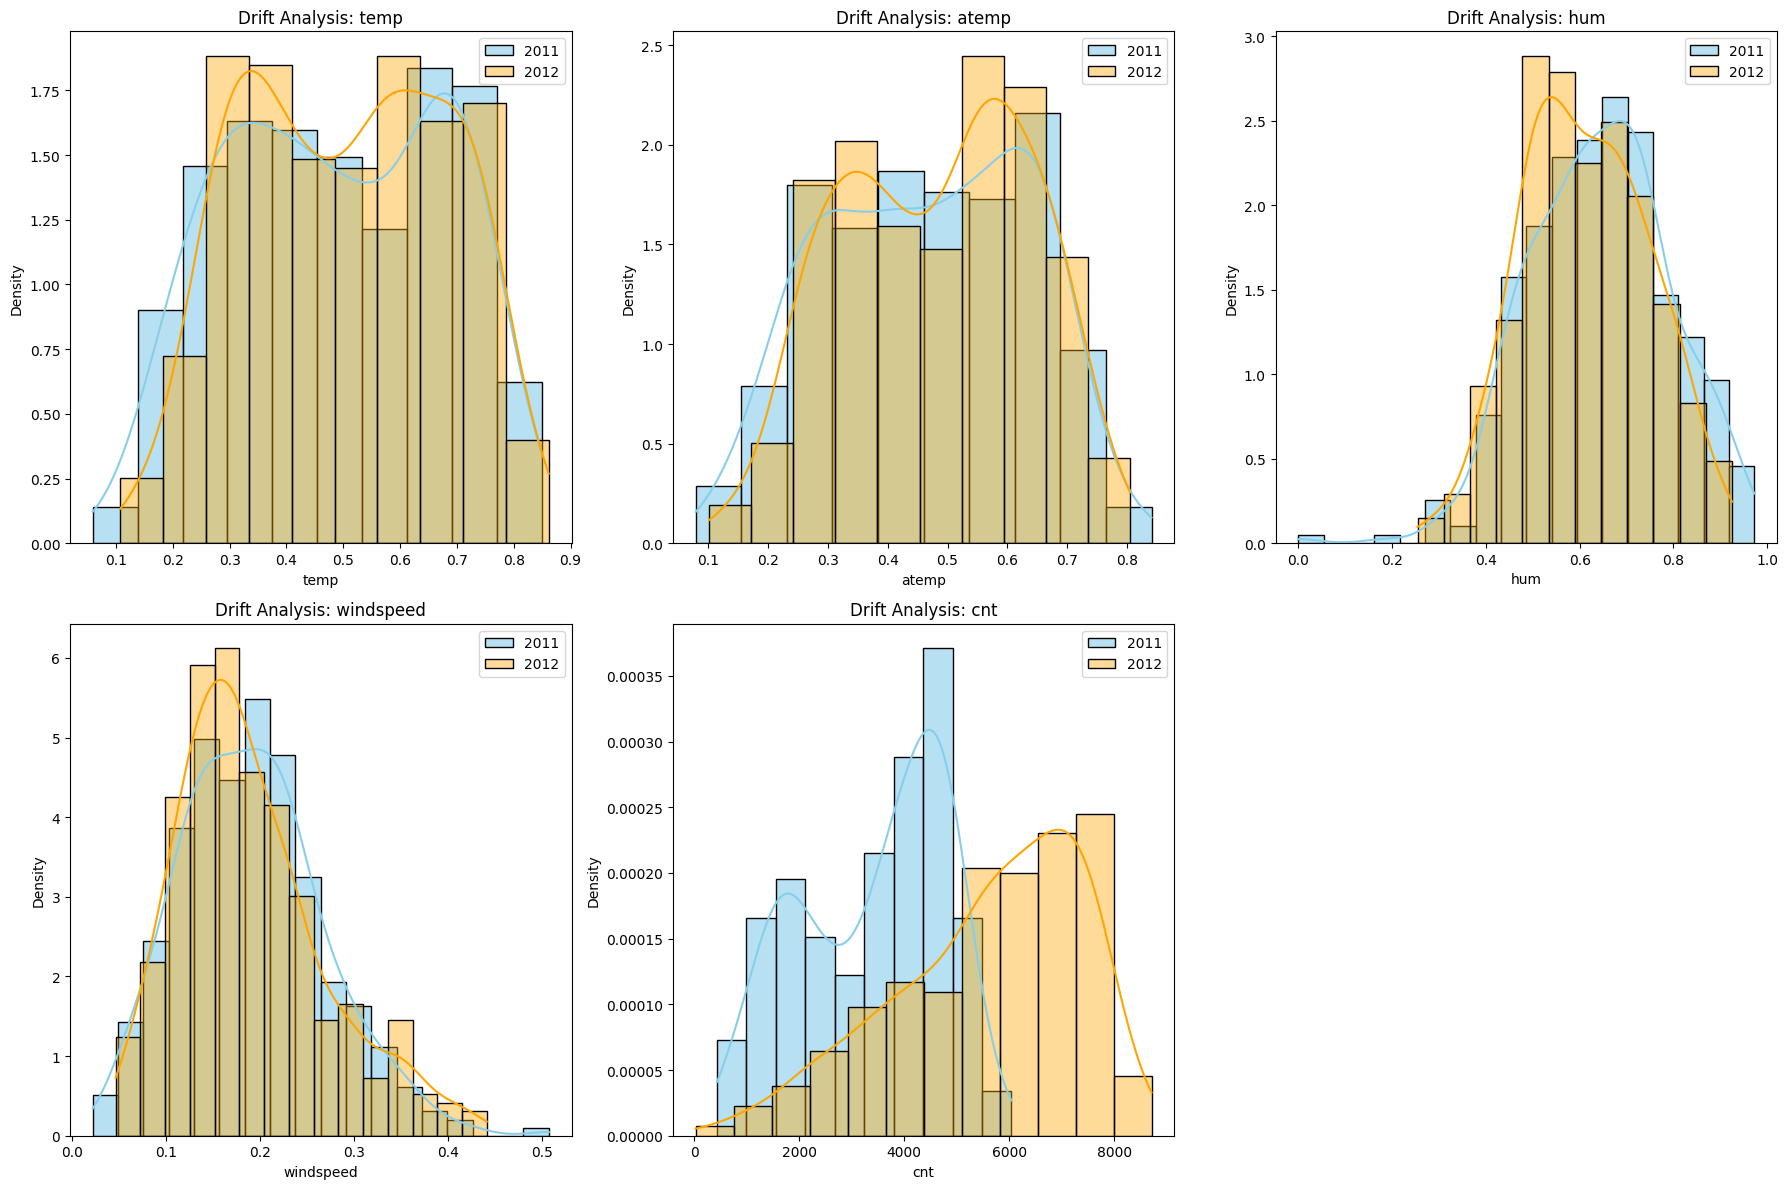

In [20]:
features_to_plot = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

# 3. Create the Plot Grid
plt.figure(figsize=(18, 12)) # Adjust size as needed

for i, col in enumerate(features_to_plot):
    plt.subplot(2, 3, i + 1) # Creates a grid of subplots (2 rows, 3 cols)
    
    # Plot 2011 (Blue)
    sns.histplot(data[col], color="skyblue", label="2011", kde=True, stat="density", alpha=0.6)
    
    # Plot 2012 (Orange) - Overlaying it
    sns.histplot(data_2012[col], color="orange", label="2012", kde=True, stat="density", alpha=0.4)
    
    plt.title(f'Drift Analysis: {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

After comparing the 2011 and 2012 data, we can conclude that the main type of drift that occured was Concept Drift.

1. Concept Drift

The most significant change between the 2021 and 2022 data was observed in the target variable, cnt. This is known as Concept Drift, where the statistical properties of the target variable change over time.

- Visual Evidence

    - Referencing the histogram, we can see that the blue curve representing the 2011 data is centered around lower values, peaking near 4000.

    - The orange curve representing the 2012 data has shifted significantly to the right, now peaking at close to 8000. 

    - There is very little overlap between the peaks, indicting that a typical day in 2012 had much higher demand than a typical day in 2011

- Statistical Evidence

    - Mean: The average daily rental count increased drastically from 3405 bicycles daily in 2011 to 5599 bicycles in 2012. This is an increase of approximately 64%

    - Standard Deviation: The variability increased from about 1378 bicycles to 1788 bicycles, showing that 2012 had a wider range of high-demand days.

2. Feature Drift

In contrast to the target, the input features showed minimal to no drift. This is expected, as weather patterns generally remain consistent year-over-year.

- Visual Evidence

    - Looking at the histograms for temp, atemp, hum, and windspeed, we can see that the Blue and Orange density curves largely overlap.

    - There is no distinct left or right shift. For example, the temp distribution shape is nearly identical for both years. 

- Statistical Evidence

    - temp - The mean barely moved, shifting from 0.487 in 2011 to 0.504 in 2012.

    - windspeed - The mean is almost identical, changing from 0.191 in 2011 to 0.189 in 2012. 

    - hum - There was a slight decrease in the mean from 0.644 to 0.612, but the overall distribution shape remains similar.

Overall, there is no significant covvariate shift for the weather aspects of the data in 2012 compared to 2011. However, ther was significant change in the target variable, thus between 2011 and 2012, Concept Drift occured.

KS Statistic: 0.5982
P-Value: 0.000000000000000000000000000000
🚨 DRIFT DETECTED: The distributions are significantly different (Reject H0)


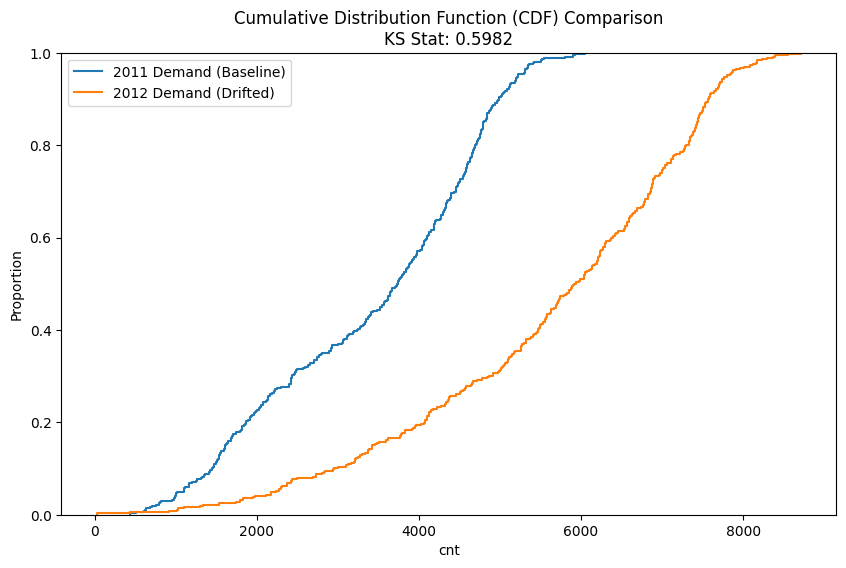

In [27]:
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Select the target variable we suspect has drifted
# Assuming you have two dataframes: df_2011 (training) and df_2012 (production/drifted)
target_2011 = data['cnt']
target_2012 = data_2012['cnt']

# 2. Run the KS Test
statistic, p_value = ks_2samp(target_2011, target_2012)

print(f"KS Statistic: {statistic:.4f}")
print(f"P-Value: {p_value:.30f}")  # formatted to show very small numbers

# 3. Interpret the Result
alpha = 0.05  # Standard significance level (5%)
if p_value < alpha:
    print("🚨 DRIFT DETECTED: The distributions are significantly different (Reject H0)")
else:
    print("✅ NO DRIFT: The distributions look similar (Fail to reject H0)")

# 4. (Optional) Visualize the CDFs to see 'where' the drift is
# The KS statistic is simply the maximum vertical distance between these two lines
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=target_2011, label="2011 Demand (Baseline)")
sns.ecdfplot(data=target_2012, label="2012 Demand (Drifted)")
plt.title(f"Cumulative Distribution Function (CDF) Comparison\nKS Stat: {statistic:.4f}")
plt.legend()
plt.show()

This graph confirms that there is Concept Drift. We can see that the median amount for the 2011 data is about 3500 to 4000. On the other hand, the median amount for the 2012 data is closer to 6000. We can see that there is little to no overlap with the orange line being much further to the right of the blue line. This proves that the demand in 2012 was consistently higher than in 2011. The KS Statistic is 0.5982, which confirms that the two years look very different. 

In [22]:
data_2012 = pd.get_dummies(data_2012, columns=['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'], drop_first=True, dtype=int)
data_2012.head()

,temp,atemp,hum,windspeed,cnt,day,year,season_2,season_3,season_4,...,holiday_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,workingday_1,weathersit_2,weathersit_3
0,0.370000,0.375621,0.692500,0.192167,2294,1,2012,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.273043,0.252304,0.381304,0.329665,1951,2,2012,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2,0.150000,0.126275,0.441250,0.365671,2236,3,2012,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,0.107500,0.119337,0.414583,0.184700,2368,4,2012,0,0,0,...,0,0,0,1,0,0,0,1,1,0
4,0.265833,0.278412,0.524167,0.129987,3272,5,2012,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [23]:
X_train_2012, X_test_2012, y_train_2012, y_test_2012 = train_test_split(
    data_2012.drop(columns=['cnt']),
    data_2012['cnt'],
    test_size=0.2,
    random_state=42
)

In [25]:
y_pred_2012 = best_model_rf.predict(X_test_2012)
rmse_2012 = np.sqrt(mean_squared_error(y_test_2012, y_pred_2012))
r2_2012 = r2_score(y_test_2012, y_pred_2012)
mae_2012 = mean_absolute_error(y_test_2012, y_pred_2012)
print(f"2012 Data - RMSE: {rmse_2012}")
print(f"2012 Data - R2: {r2_2012}")
print(f"2012 Data - MAE: {mae_2012}")

2012 Data - RMSE: 2173.1942274007124
2012 Data - R2: -0.43880396416534473
2012 Data - MAE: 2020.7945054738805


In [26]:
y_pred_2012 = lr.predict(X_test_2012)
rmse_2012 = np.sqrt(mean_squared_error(y_test_2012, y_pred_2012))
r2_2012 = r2_score(y_test_2012, y_pred_2012)
mae_2012 = mean_absolute_error(y_test_2012, y_pred_2012)
print(f"2012 Data - RMSE: {rmse_2012}")
print(f"2012 Data - R2: {r2_2012}")
print(f"2012 Data - MAE: {mae_2012}")

2012 Data - RMSE: 2440.9502997784266
2012 Data - R2: -0.8151913522274554
2012 Data - MAE: 2229.3893404749906


| Metric | 2011 Performance (Baseline) | 2012 Performance (Drifted) | Change |
|:----:|:----:|:----:|:----:|
| RMSE | 648.02 | 2440.95 | 376.68% Increase |
| MAE | 451.14 | 2229.39 | 494.17% Increase |
| R2 | 0.775 | -0.815 | Dropped to Negative (Model Failure) |

- The R2 value dropped from a healthy 0.775 in 2011 to -0.815 in 2012. This negative score confirms the model is completely ineffective on the new data

- This degradation in performance is consistent with the Concept Drift identified earlier, where the 2012 demand far exceeded the maximum range the model learned from the 2011 data